In [1]:
import numpy as np
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from keras.layers import Activation, Dropout, Convolution2D, GlobalAveragePooling2D
from keras.models import Sequential
import tensorflow as tf
import tensorflow.keras.applications.mobilenet
import os
import pandas as pd
import glob # 파일들의 리스트를 뽑을 때, 파일의 경로를 이용하여 다양하게 사용 가능
import seaborn as sns # matpoltlib의 파생버전, 간단하고 이쁘게 그래프를 그려주는 라이브러리
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [2]:
image_train_data = '/aiffel/aiffel/fastapi_skin/train'
train= pd.DataFrame(os.listdir(image_train_data ),columns=['train'])
train.head()

,train
0,Vascular lesion
1,Benign keratosis
2,Dermatofibroma
3,Squamous cell carcinoma
4,Tinea Ringworm Candidiasis


In [3]:
image_test_data = '/aiffel/aiffel/fastapi_skin/test'
test = pd.DataFrame(os.listdir(image_test_data ),columns=['test'])
test.head()

,test
0,Vascular lesion
1,Benign keratosis
2,Dermatofibroma
3,Squamous cell carcinoma
4,Tinea Ringworm Candidiasis


In [4]:
str_label = {
    'Actinic keratosis': 'Actinic keratosis: 광선 각화증',
    'Atopic Dermatitis': 'Atopic Dermatitis: 아토피성 피부염',
    'Benign keratosis': 'Benign keratosis: 양성 각화증',
    'Dermatofibroma': 'Dermatofibroma: 피부섬유종',
    'Melanocytic nevus': 'Melanocytic nevus: 멜라닌 세포 모반',
    'Melanoma': 'Melanoma: 흑색종',
    'Squamous cell carcinoma': 'Squamous cell carcinoma: 편평 세포 암종',
    'Tinea Ringworm Candidiasis': 'Tinea Ringworm Candidiasis: 백선 백선 칸디다증',
    'Vascular lesion': 'Vascular lesion: 혈관 병변'
}

# 파일과 라벨 리스트 생성
files = [i for i in glob.glob(image_train_data + "//*//*")]
np.random.shuffle(files)
labels = [os.path.dirname(i).split("/")[-1] for i in files]

# 데이터프레임 생성
data = zip(files, labels)
dataframe = pd.DataFrame(data, columns=["Image", "Label"])
dataframe['Label'] = dataframe['Label'].map(str_label)

In [5]:
print(dataframe.head())

                                               Image  \
0  /aiffel/aiffel/fastapi_skin/train/Benign kerat...   
1  /aiffel/aiffel/fastapi_skin/train/Actinic kera...   
2  /aiffel/aiffel/fastapi_skin/train/Actinic kera...   
3  /aiffel/aiffel/fastapi_skin/train/Atopic Derma...   
4  /aiffel/aiffel/fastapi_skin/train/Actinic kera...   

                         Label  
0     Benign keratosis: 양성 각화증  
1    Actinic keratosis: 광선 각화증  
2    Actinic keratosis: 광선 각화증  
3  Atopic Dermatitis: 아토피성 피부염  
4    Actinic keratosis: 광선 각화증  


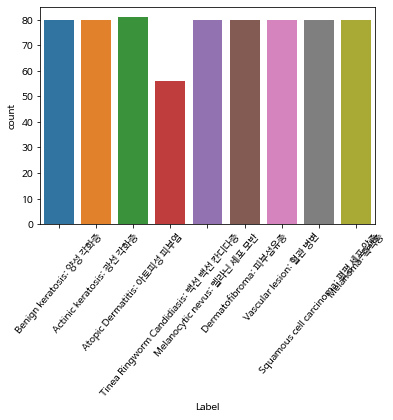

In [6]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumBarunGothic'
sns.countplot(x = dataframe["Label"])
plt.xticks(rotation = 50);

In [7]:
batch_size = 32

target_size = (224,224)
train= tf.keras.preprocessing.image_dataset_from_directory(
    image_train_data,
    validation_split=0.2,
    subset="training",
    seed=123,  # 동일한 난수 시드 사용
    image_size=target_size,
    batch_size=batch_size,
    
)

valid= tf.keras.preprocessing.image_dataset_from_directory(
    image_train_data,
    validation_split=0.2,
    subset="validation",
    seed=123,  # 동일한 난수 시드 사용
    image_size=target_size,
    batch_size=batch_size,
)

test = tf.keras.preprocessing.image_dataset_from_directory(
    image_test_data,
    validation_split=None,
    image_size=target_size,
    batch_size=batch_size,
)

Found 697 files belonging to 9 classes.
Using 558 files for training.
Found 697 files belonging to 9 classes.
Using 139 files for validation.
Found 181 files belonging to 9 classes.


In [8]:
class_names = train.class_names
for idx, name in enumerate(class_names):
    print(f"라벨{idx}에 해당하는 클래스 : {name}")

라벨0에 해당하는 클래스 : Actinic keratosis
라벨1에 해당하는 클래스 : Atopic Dermatitis
라벨2에 해당하는 클래스 : Benign keratosis
라벨3에 해당하는 클래스 : Dermatofibroma
라벨4에 해당하는 클래스 : Melanocytic nevus
라벨5에 해당하는 클래스 : Melanoma
라벨6에 해당하는 클래스 : Squamous cell carcinoma
라벨7에 해당하는 클래스 : Tinea Ringworm Candidiasis
라벨8에 해당하는 클래스 : Vascular lesion


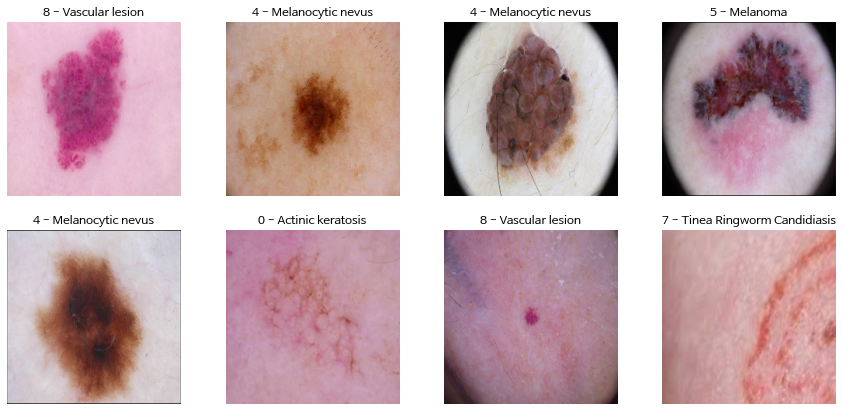

In [9]:
plt.figure(figsize=(15, 30))
for images, labels in train.take(1):
    for i in range(8):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"{labels[i]} - {class_names[labels[i]]}")
        plt.axis("off")

In [10]:
for images, labels in train:
    print(images.shape)  # 이미지 데이터의 쉐입을 출력합니다.
    print(labels.shape)  # 라벨 데이터의 쉐입을 출력합니다.
    break  # 첫 번째 배치만 확인합니다.

(32, 224, 224, 3)
(32,)


In [11]:
from tensorflow.keras import layers

# Rescaling 레이어 생성
normalization_layer = layers.Rescaling(1./255)

# 훈련, 검증, 테스트 데이터셋에 정규화 레이어 적용
train = train.map(lambda x, y: (normalization_layer(x), y))
valid = valid.map(lambda x, y: (normalization_layer(x), y))
test = test.map(lambda x, y: (normalization_layer(x), y))

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True
)
datagen1 = ImageDataGenerator()

# Convert MapDataset to NumPy arrays
train_data_numpy = train.unbatch().as_numpy_iterator()
valid_data_numpy = valid.unbatch().as_numpy_iterator()

# Extract images and labels
train_images, train_labels = zip(*train_data_numpy)
valid_images, valid_labels = zip(*valid_data_numpy)

# Convert to NumPy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)
valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)

# Apply data augmentation
augmented_train = datagen.flow(train_images, train_labels, batch_size=32)
augmented_val = datagen1.flow(valid_images, valid_labels, batch_size=32)

In [13]:
datagen2 = ImageDataGenerator()

# Convert MapDataset to NumPy arrays
test_data_numpy = test.unbatch().as_numpy_iterator()

# Extract images and labels
test_images, test_labels = zip(*test_data_numpy)

# Convert to NumPy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)


# Apply data augmentation
test_generator = datagen2.flow(test_images, test_labels, batch_size = 32)

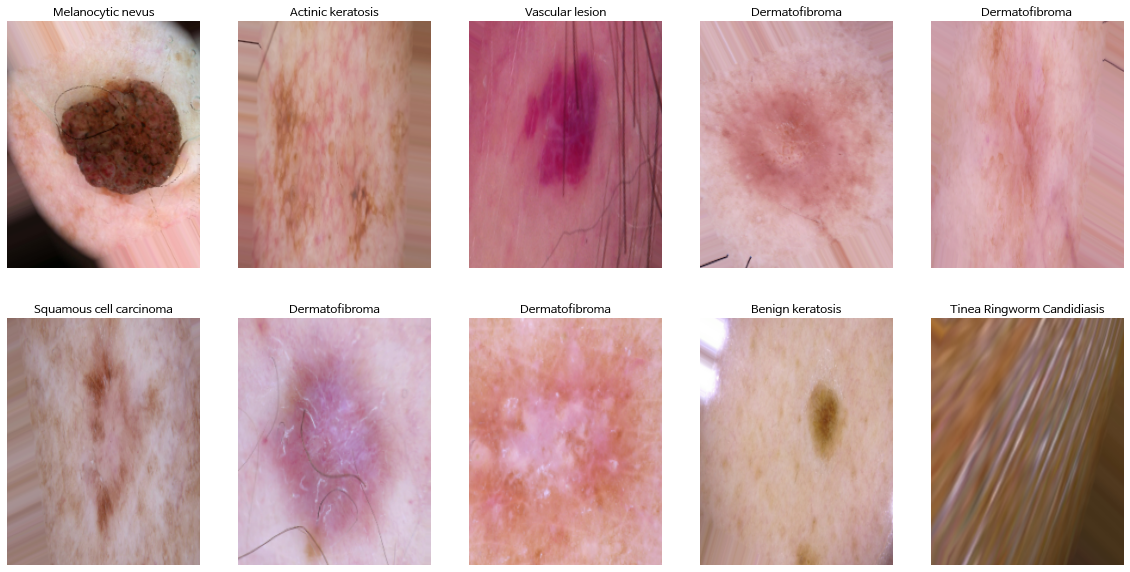

In [14]:
# 시각화를 위한 코드
plt.figure(figsize=(20, 10))

# augmented_train에서 데이터를 가져와 시각화
num_batches = 2  # 시각화할 배치의 수
images_per_batch = 5  # 각 배치에서 시각화할 이미지 수

for i in range(num_batches):
    augmented_images, augmented_labels = augmented_train.next()  # 다음 증강된 데이터 배치를 가져옴
    for j in range(images_per_batch):
        plt.subplot(num_batches, images_per_batch, i * images_per_batch + j + 1)
        plt.imshow((augmented_images[j] * 255).astype('uint8'), cmap='gray', aspect='auto')
        plt.title(class_names[augmented_labels[j]])
        plt.axis('off')

plt.show()

In [21]:
from tensorflow.keras.applications import InceptionV3
IMG_SHAPE = (224, 224, 3)

# DenseNet121 모델을 불러오기
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

87924736/87910968 [==============================] - 1s 0us/step


In [22]:
feature_batch = base_model(augmented_images)
feature_batch.shape

TensorShape([32, 5, 5, 2048])

In [23]:
# Base_model 구조 확인
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [24]:
# 글로벌 어버리지를 통해서 크기만 줄이고 그대로 남기겠다.
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

# 레이어 구성후 마지막 소프트맥스의 units 값을 9로 만들어준다.
dense_layer = tf.keras.layers.Dense(
    units=512,
    activation='relu'
)

# unit은 우리가 분류하고 싶은 class는 9개였기 때문에 9로 유닛을 준다.
# 활성화 함수는 Softmax를 사용
prediction_layer = tf.keras.layers.Dense(
    units=9,
    activation='softmax'
)

# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))
print(prediction_batch.shape)

(32, 9)


In [25]:
# 사전 훈련된 모델 고정하기
base_model.trainable = False
# 최종모델
model = tf.keras.Sequential([
    base_model,             # 베이스 모델
    global_average_layer,   # 글로벌 평균 풀링 레이어
    dense_layer,            # 밀집 레이어 (ReLU 활성화)
    prediction_layer        # 예측 레이어 (Softmax 활성화)
])
# 구조 확인
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 4617      
Total params: 22,856,489
Trainable params: 1,053,705
Non-trainable params: 21,802,784
_________________________________________________________________


In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 컴파일!
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# 콜백 함수 정의
checkpoint_callback = ModelCheckpoint("/aiffel/aiffel/fastapi_skin/best_model.h5", save_best_only=True)
early_stopping_callback = EarlyStopping(patience=5, restore_best_weights=True)

# 모델 훈련
history = model.fit(augmented_train,
                         epochs=50,
                         validation_data=augmented_val,
                         callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/50
18/18 [==============================] - 13s 467ms/step - loss: 2.3522 - accuracy: 0.0860 - val_loss: 2.2872 - val_accuracy: 0.0863
Epoch 2/50
18/18 [==============================] - 6s 333ms/step - loss: 2.2340 - accuracy: 0.1272 - val_loss: 2.2184 - val_accuracy: 0.1151
Epoch 3/50
18/18 [==============================] - 6s 339ms/step - loss: 2.1470 - accuracy: 0.1774 - val_loss: 2.1632 - val_accuracy: 0.1583
Epoch 4/50
18/18 [==============================] - 6s 330ms/step - loss: 2.0608 - accuracy: 0.2025 - val_loss: 2.1049 - val_accuracy: 0.1799
Epoch 5/50
18/18 [==============================] - 6s 336ms/step - loss: 2.0051 - accuracy: 0.2670 - val_loss: 2.0518 - val_accuracy: 0.2014
Epoch 6/50
18/18 [==============================] - 6s 332ms/step - loss: 1.9630 - accuracy: 0.3118 - val_loss: 2.0047 - val_accuracy: 0.2374
Epoch 7/50
18/18 [==============================] - 6s 340ms/step - loss: 1.8983 - accuracy: 0.3262 - val_loss: 1.9595 - val_accuracy: 0.2590
Epoch

In [27]:
from tensorflow.keras.models import load_model
model = load_model('best_model.h5')
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
       "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})

6/6 [==============================] - 3s 286ms/step - loss: 1.1328 - accuracy: 0.6077
{'Test Accuracy Rate: ': 60.77, 'Test Error Rate: ': 39.23}
